In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [28]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_14.h5ad')
adata

AnnData object with n_obs × n_vars = 6102 × 3058
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'cell_type', 'cell_type_int', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

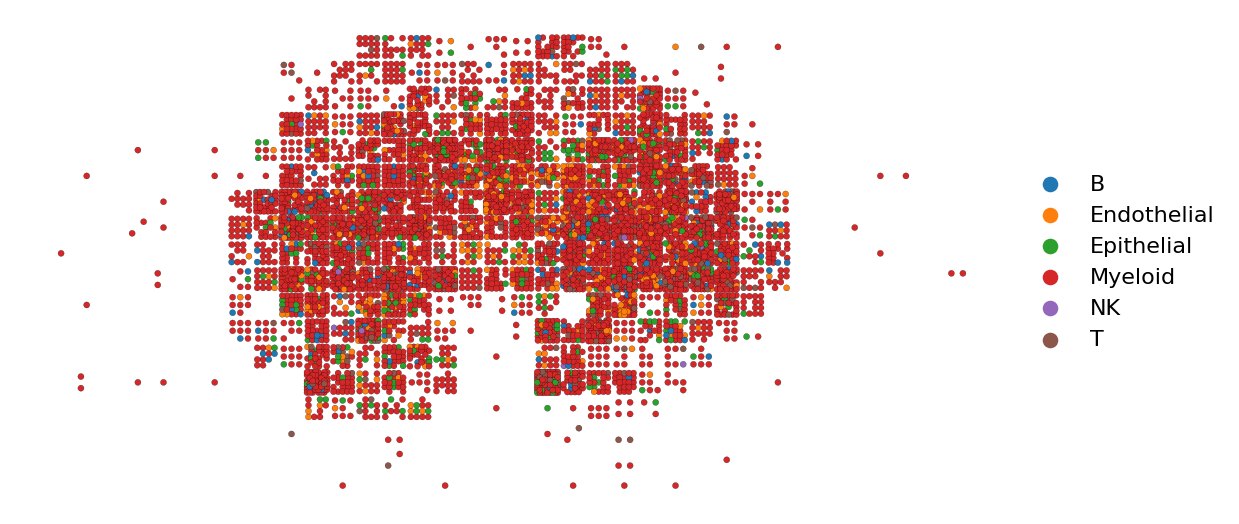

In [29]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams['figure.dpi'] = 160
sc.pl.embedding(adata, basis='spatial', color='cell_type', 
    frameon=False, edgecolor='black', s=30, linewidth=0.1, title='')


In [30]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [31]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

In [32]:
adata.X.max()

6495.0

In [33]:
adata.X = adata.layers['normalized_count'].copy()

In [34]:
adata.X.max()

8.778942

In [35]:
# %%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')
sc.tl.umap(adata)

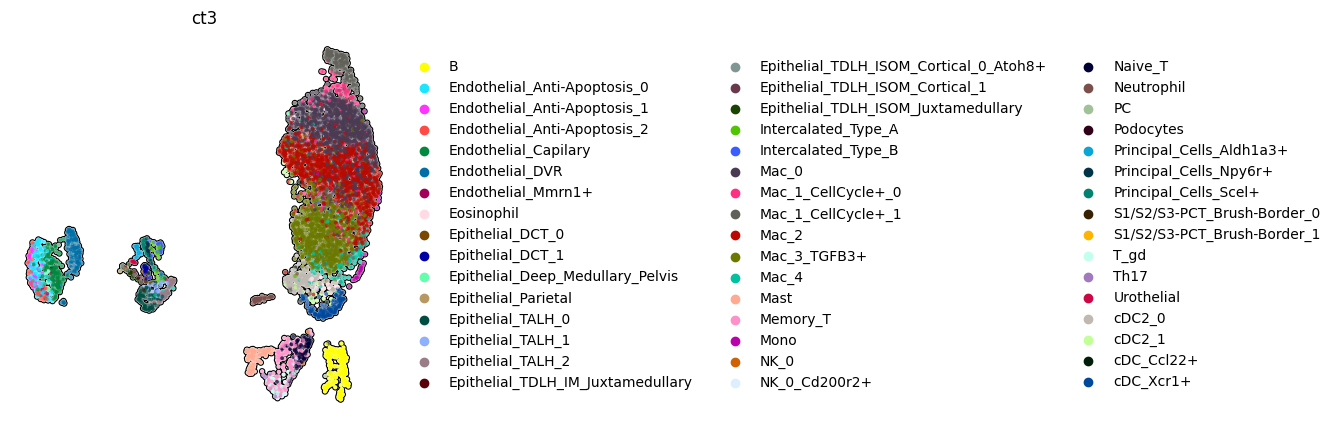

In [36]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100

sc.pl.umap(adata, color='ct3', frameon=False, s=30, add_outline=True)

In [37]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [38]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [39]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=0
)

KeyError: 'imputed_count'

In [35]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
import pickle

with open('/Users/koush/Desktop/training_data/mouse_kidney_13_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [37]:
# adata.write_h5ad('/Users/koush/Desktop/training_data/mouse_kidney_13.h5ad')